In [265]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, AutoNHITS, NBEATS, AutoNBEATS, TimesNet, AutoTimesNet, TFT, AutoTFT, LSTM, AutoLSTM, RNN

from neuralforecast.losses.numpy import mae, mse, mape

In [226]:
pd.set_option('display.max_rows', None)

In [227]:
plt.rcParams["figure.figsize"] = (10,6)

In [228]:
file_name = 'data/Multiple_sample_series.csv'

## Read data 

In [229]:
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,Date,Timeseries ID,ID,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,0,2015-04-09,BE,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10797.0
1,1,2015-04-09,PT,PT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5802.0
2,2,2015-04-09,RO,RO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6513.0
3,3,2015-04-10,BE,BE,10141.0,9462.0,8995.0,8890.0,8861.0,9020.0,...,10861.0,10679.0,10500.0,10330.0,10368.0,10206.0,9981.0,10321.0,10125.0,10379.0
4,4,2015-04-10,PT,PT,5248.0,4784.0,4487.0,4312.0,4229.0,4220.0,...,6047.0,6181.0,6092.0,5979.0,5766.0,5672.0,5787.0,6266.0,6136.0,5728.0


In [230]:
df.columns

Index(['Unnamed: 0', 'Date', 'Timeseries ID', 'ID', '00:00:00', '01:00:00',
       '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00',
       '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00',
       '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00',
       '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
      dtype='object')

In [231]:
df = df.drop(columns=['Unnamed: 0', 'Timeseries ID'], axis=1)
df.head()

,Date,ID,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2015-04-09,BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10797.0
1,2015-04-09,PT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5802.0
2,2015-04-09,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6513.0
3,2015-04-10,BE,10141.0,9462.0,8995.0,8890.0,8861.0,9020.0,9935.0,10457.0,...,10861.0,10679.0,10500.0,10330.0,10368.0,10206.0,9981.0,10321.0,10125.0,10379.0
4,2015-04-10,PT,5248.0,4784.0,4487.0,4312.0,4229.0,4220.0,4297.0,4504.0,...,6047.0,6181.0,6092.0,5979.0,5766.0,5672.0,5787.0,6266.0,6136.0,5728.0


In [232]:
# Melt the DataFrame to unpivot it
melted_df = pd.melt(df, id_vars=['Date', 'ID'], var_name='Hour', value_name='Value')

# # Combine 'Date' and 'Hour' columns into a new 'Datetime' column
melted_df['Datetime'] = pd.to_datetime(melted_df['Date'] + ' ' + melted_df['Hour'])

# # Drop the original 'Date' and 'Hour' columns if needed
melted_df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Change the order of columns
new_order = ['Datetime', 'ID', 'Value']
melted_df = melted_df[new_order]

# # Display the reshaped DataFrame
print(melted_df.head())

    Datetime  ID    Value
0 2015-04-09  BE      NaN
1 2015-04-09  PT      NaN
2 2015-04-09  RO      NaN
3 2015-04-10  BE  10141.0
4 2015-04-10  PT   5248.0


In [233]:
melted_df.dtypes

Datetime    datetime64[ns]
ID                  object
Value              float64
dtype: object

In [234]:
# Rename columns
column_mapping = {'Datetime': 'ds', 'ID': 'unique_id', 'Value': 'y'}
melted_df.rename(columns=column_mapping, inplace=True)
melted_df.head()

,ds,unique_id,y
0,2015-04-09,BE,NaN
1,2015-04-09,PT,NaN
2,2015-04-09,RO,NaN
3,2015-04-10,BE,10141.0
4,2015-04-10,PT,5248.0


In [235]:
melted_df.tail()

,ds,unique_id,y
183475,2022-03-31 23:00:00,PT,6473.0
183476,2022-03-31 23:00:00,RO,5950.0
183477,2022-04-01 23:00:00,BE,NaN
183478,2022-04-01 23:00:00,PT,NaN
183479,2022-04-01 23:00:00,RO,NaN


In [236]:
melted_df.describe()

,ds,y
count,183480,182994.000000
mean,2018-10-05 00:15:06.710267904,7402.210980
min,2015-04-09 00:00:00,3160.000000
25%,2017-01-05 17:45:00,5823.000000
50%,2018-10-05 03:30:00,7018.000000
75%,2020-07-03 05:15:00,8822.750000
max,2022-04-01 23:00:00,13710.000000
std,NaN,2067.769206


**Replace the NaN values wilth "mean" value of that column for each unique_id separately**

In [237]:
melted_df['y'] = melted_df['y'].fillna(melted_df.groupby('unique_id')['y'].transform('mean'))
print ('melted_df.head():\n', melted_df.head())
print ('\nmelted_df.tail():\n', melted_df.tail())

melted_df.head():
           ds unique_id             y
0 2015-04-09        BE   9752.266601
1 2015-04-09        PT   5665.600694
2 2015-04-09        RO   6783.562232
3 2015-04-10        BE  10141.000000
4 2015-04-10        PT   5248.000000

melted_df.tail():
                         ds unique_id            y
183475 2022-03-31 23:00:00        PT  6473.000000
183476 2022-03-31 23:00:00        RO  5950.000000
183477 2022-04-01 23:00:00        BE  9752.266601
183478 2022-04-01 23:00:00        PT  5665.600694
183479 2022-04-01 23:00:00        RO  6783.562232


In [238]:
melted_df.describe()

,ds,y
count,183480,183480.000000
mean,2018-10-05 00:15:06.710267904,7400.879985
min,2015-04-09 00:00:00,3160.000000
25%,2017-01-05 17:45:00,5825.000000
50%,2018-10-05 03:30:00,7013.000000
75%,2020-07-03 05:15:00,8818.250000
max,2022-04-01 23:00:00,13710.000000
std,NaN,2065.818707


**Plot All TimeSeries**

In [239]:
# Pivot the DataFrame to reshape it for plotting
df_pivot = melted_df.pivot(index='ds', columns='unique_id', values='y')
df_pivot.head()

unique_id,BE,PT,RO
ds,,,
2015-04-09 00:00:00,9752.266601,5665.600694,6783.562232
2015-04-09 01:00:00,9752.266601,5665.600694,6783.562232
2015-04-09 02:00:00,9752.266601,5665.600694,6783.562232
2015-04-09 03:00:00,9752.266601,5665.600694,6783.562232
2015-04-09 04:00:00,9752.266601,5665.600694,6783.562232


In [240]:
df_pivot.describe()

unique_id,BE,PT,RO
count,61200.000000,61200.000000,61080.000000
mean,9752.266601,5665.600694,6783.562232
std,1353.318058,995.958355,1025.943630
min,6202.000000,3160.000000,4087.000000
25%,8687.000000,4817.000000,5976.000000
50%,9759.000000,5640.000000,6776.000000
75%,10761.000000,6399.250000,7472.000000
max,13710.000000,9833.000000,9728.000000


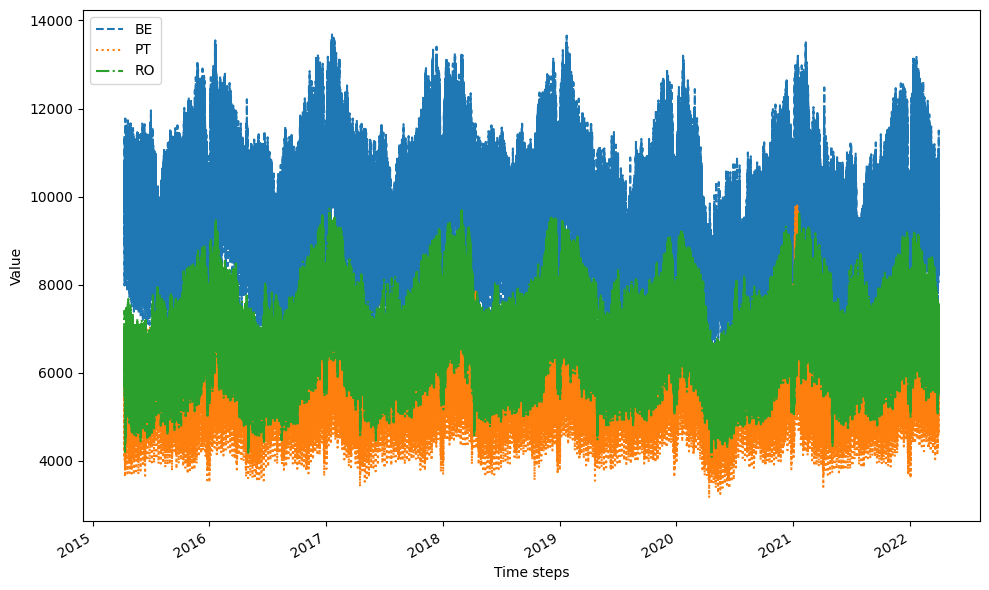

In [241]:
fig, ax = plt.subplots()

ax.plot(df_pivot['BE'], label='BE', ls='--')
ax.plot(df_pivot['PT'], label='PT', ls=':')
ax.plot(df_pivot['RO'], label='RO', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

**PLot the Series separately, to avoid overlap**

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>],
      dtype=object)

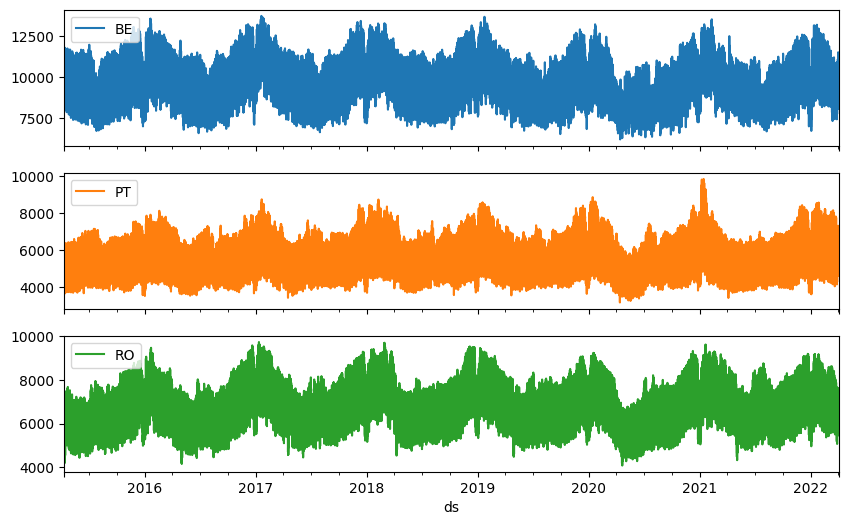

In [242]:
df_pivot.plot(subplots=True, legend=True)

**Visualize the plots for "Jan 2020" only**

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>],
      dtype=object)

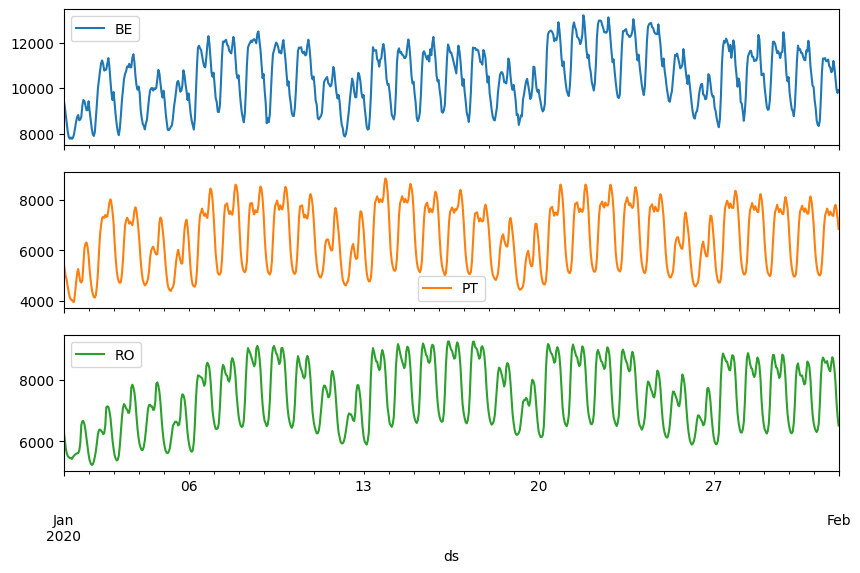

In [243]:
# Define a date range for filtering
start_date = '2020-01-01 00:00:00'
end_date = '2020-02-01 00:00:00'

df_pivot.loc[start_date:end_date].plot(subplots=True, legend=True)

**Visualize the plots for "Feb 2020" only**

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>],
      dtype=object)

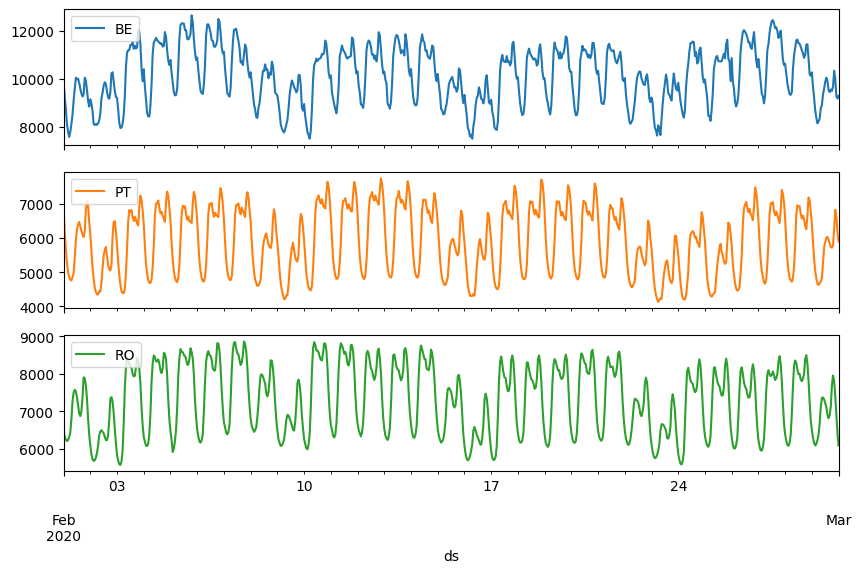

In [244]:
# Define a date range for filtering
start_date = '2020-02-01 00:00:00'
end_date = '2020-03-01 00:00:00'

df_pivot.loc[start_date:end_date].plot(subplots=True, legend=True)

**The values for "2023-04-01" were repalced by the mean of the respective timeseries since they were initially nulls. For forecasting we can ignore these values and check the predictions on timestamps for which "true" values are given.**

In [245]:
melted_df_with_index = melted_df.set_index('ds')
melted_df_with_index = melted_df_with_index.sort_index()

In [246]:

start_date = '2022-04-01 01:00:00'

melted_df_filtered = melted_df_with_index.loc[:start_date]
print (melted_df_filtered.tail())

                    unique_id       y
ds                                   
2022-04-01 00:00:00        PT  5841.0
2022-04-01 00:00:00        BE  9918.0
2022-04-01 01:00:00        RO  5564.0
2022-04-01 01:00:00        PT  5247.0
2022-04-01 01:00:00        BE  9291.0


**Reset the index as the dataframe column, to make compatible with NeuralForecast input**

In [247]:
melted_df_filtered = melted_df_filtered.reset_index()
melted_df_filtered.head()

,ds,unique_id,y
0,2015-04-09 00:00:00,BE,9752.266601
1,2015-04-09 00:00:00,PT,5665.600694
2,2015-04-09 00:00:00,RO,6783.562232
3,2015-04-09 01:00:00,RO,6783.562232
4,2015-04-09 01:00:00,PT,5665.600694


## Model 

In [248]:
# horizon = 96
horizon = 24
# max_steps = 50
train_steps = 100
# window_factor = 2
window_factor = 7

models = [NHITS(h=horizon,
               input_size=window_factor*horizon,
               max_steps=train_steps),
         NBEATS(h=horizon,
               input_size=window_factor*horizon,
               max_steps=train_steps),
         TimesNet(h=horizon,
                 input_size=window_factor*horizon,
                 max_steps=train_steps)]

Seed set to 1
Seed set to 1
Seed set to 1


In [249]:
nf = NeuralForecast(models=models, freq='H')

In [250]:
preds_df = nf.cross_validation(df=melted_df_filtered, step_size=horizon, n_windows=2)

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=54, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]        

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


In [251]:
print (preds_df)

    unique_id                  ds              cutoff         NHITS  \
0          BE 2022-03-30 02:00:00 2022-03-30 01:00:00   8296.341797   
1          BE 2022-03-30 03:00:00 2022-03-30 01:00:00   8075.960449   
2          BE 2022-03-30 04:00:00 2022-03-30 01:00:00   8059.754883   
3          BE 2022-03-30 05:00:00 2022-03-30 01:00:00   8255.541016   
4          BE 2022-03-30 06:00:00 2022-03-30 01:00:00   8577.505859   
5          BE 2022-03-30 07:00:00 2022-03-30 01:00:00   9062.767578   
6          BE 2022-03-30 08:00:00 2022-03-30 01:00:00   9527.957031   
7          BE 2022-03-30 09:00:00 2022-03-30 01:00:00  10000.317383   
8          BE 2022-03-30 10:00:00 2022-03-30 01:00:00  10235.866211   
9          BE 2022-03-30 11:00:00 2022-03-30 01:00:00  10360.535156   
10         BE 2022-03-30 12:00:00 2022-03-30 01:00:00  10280.722656   
11         BE 2022-03-30 13:00:00 2022-03-30 01:00:00  10134.348633   
12         BE 2022-03-30 14:00:00 2022-03-30 01:00:00   9924.583008   
13    

Text(0.5, 1.0, 'Predictions for Combined TimeSeries')

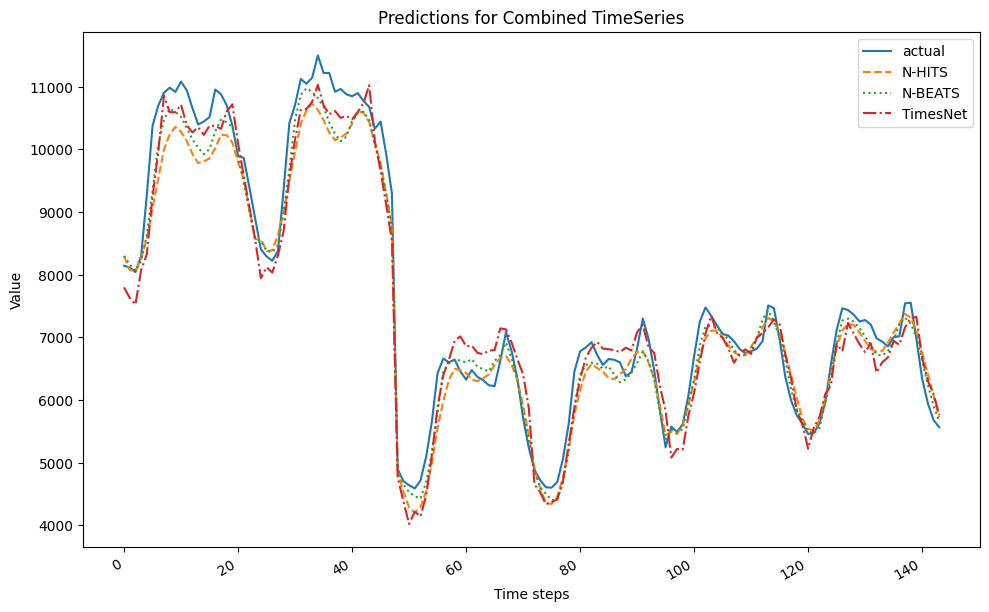

In [252]:
# preds_df_with_index = preds_df.set_index('ds')

fig, ax = plt.subplots()

ax.plot(preds_df['y'], label='actual')
ax.plot(preds_df['NHITS'], label='N-HITS', ls='--')
ax.plot(preds_df['NBEATS'], label='N-BEATS', ls=':')
ax.plot(preds_df['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Predictions for Combined TimeSeries')

In [253]:
# Pivot the DataFrame to reshape it for plotting
preds_df_pivot = preds_df.pivot(index='ds', columns='unique_id', values=['NHITS','NBEATS','TimesNet','y'])
preds_df_pivot.head()

NHITS                                 NBEATS  \
unique_id                     BE           PT           RO           BE   
ds                                                                        
2022-03-30 02:00:00  8296.341797  4875.539551  5496.918945  8301.155273   
2022-03-30 03:00:00  8075.960449  4538.582520  5458.537598  8164.000977   
2022-03-30 04:00:00  8059.754883  4287.547852  5597.629883  8062.555664   
2022-03-30 05:00:00  8255.541016  4205.304199  5915.615234  8221.106445   
2022-03-30 06:00:00  8577.505859  4292.701172  6293.900879  8633.734375   

                                                  TimesNet               \
unique_id                     PT           RO           BE           PT   
ds                                                                        
2022-03-30 02:00:00  4892.521484  5528.764160  7799.032227  4765.138672   
2022-03-30 03:00:00  4654.036133  5483.237305  7628.122559  4387.737305   
2022-03-30 04:00:00  4531.967285  5536.423828  7524.843262  4023.302246   
2022-03-30 05:00:00  4465.011230  5936.830566  8075.789062  4218.832031   
2022-03-30 06:00:00  4428.626953  6328.861328  8326.904297  4143.645996   

                                       y                  
unique_id                     RO      BE      PT      RO  
ds                                                        
2022-03-30 02:00:00  5084.316406  8143.0  4896.0  5577.0  
2022-03-30 03:00:00  5220.745117  8116.0  4709.0  5493.0  
2022-03-30 04:00:00  5209.289062  8042.0  4641.0  5614.0  
2022-03-30 05:00:00  5752.828125  8299.0  4590.0  6073.0  
2022-03-30 06:00:00  6114.766113  9275.0  4717.0  6701.0

In [254]:
preds_df_pivot.columns

MultiIndex([(   'NHITS', 'BE'),
            (   'NHITS', 'PT'),
            (   'NHITS', 'RO'),
            (  'NBEATS', 'BE'),
            (  'NBEATS', 'PT'),
            (  'NBEATS', 'RO'),
            ('TimesNet', 'BE'),
            ('TimesNet', 'PT'),
            ('TimesNet', 'RO'),
            (       'y', 'BE'),
            (       'y', 'PT'),
            (       'y', 'RO')],
           names=[None, 'unique_id'])

**Collapse the Multiindex Columns to a Single Index Columns**

In [255]:
preds_df_pivot.columns = preds_df_pivot.columns.map('_'.join)
preds_df_pivot.columns

Index(['NHITS_BE', 'NHITS_PT', 'NHITS_RO', 'NBEATS_BE', 'NBEATS_PT',
       'NBEATS_RO', 'TimesNet_BE', 'TimesNet_PT', 'TimesNet_RO', 'y_BE',
       'y_PT', 'y_RO'],
      dtype='object')

In [256]:
preds_df_pivot.head()

,NHITS_BE,NHITS_PT,NHITS_RO,NBEATS_BE,NBEATS_PT,NBEATS_RO,TimesNet_BE,TimesNet_PT,TimesNet_RO,y_BE,y_PT,y_RO
ds,,,,,,,,,,,,
2022-03-30 02:00:00,8296.341797,4875.539551,5496.918945,8301.155273,4892.521484,5528.764160,7799.032227,4765.138672,5084.316406,8143.0,4896.0,5577.0
2022-03-30 03:00:00,8075.960449,4538.582520,5458.537598,8164.000977,4654.036133,5483.237305,7628.122559,4387.737305,5220.745117,8116.0,4709.0,5493.0
2022-03-30 04:00:00,8059.754883,4287.547852,5597.629883,8062.555664,4531.967285,5536.423828,7524.843262,4023.302246,5209.289062,8042.0,4641.0,5614.0
2022-03-30 05:00:00,8255.541016,4205.304199,5915.615234,8221.106445,4465.011230,5936.830566,8075.789062,4218.832031,5752.828125,8299.0,4590.0,6073.0
2022-03-30 06:00:00,8577.505859,4292.701172,6293.900879,8633.734375,4428.626953,6328.861328,8326.904297,4143.645996,6114.766113,9275.0,4717.0,6701.0


Text(0.5, 1.0, 'Predictions for BE TimeSeries')

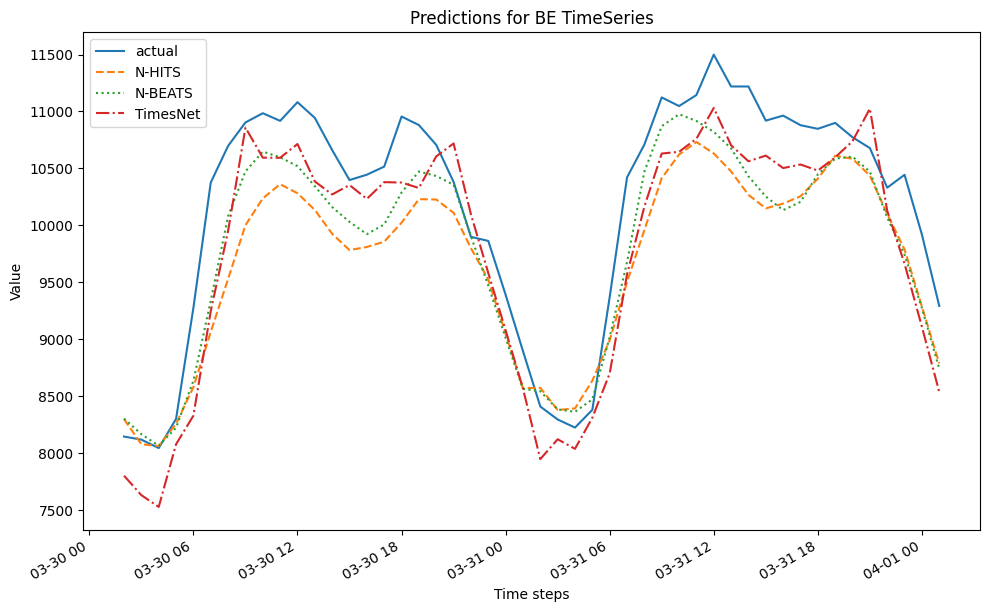

In [257]:
fig, ax = plt.subplots()

ax.plot(preds_df_pivot['y_BE'], label='actual')
ax.plot(preds_df_pivot['NHITS_BE'], label='N-HITS', ls='--')
ax.plot(preds_df_pivot['NBEATS_BE'], label='N-BEATS', ls=':')
ax.plot(preds_df_pivot['TimesNet_BE'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Predictions for BE TimeSeries')

Text(0.5, 1.0, 'Predictions for PT TimeSeries')

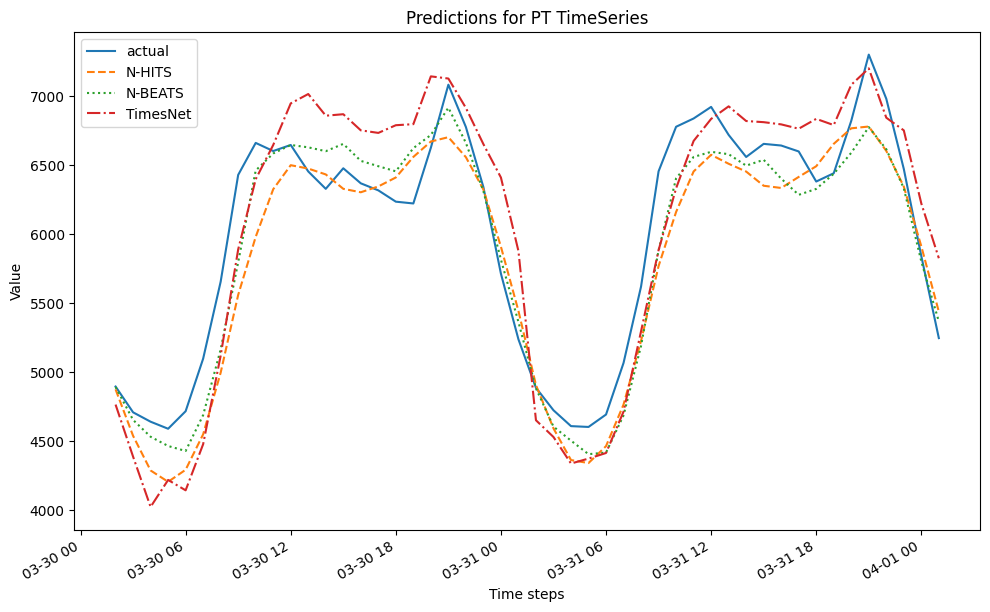

In [258]:
fig, ax = plt.subplots()

ax.plot(preds_df_pivot['y_PT'], label='actual')
ax.plot(preds_df_pivot['NHITS_PT'], label='N-HITS', ls='--')
ax.plot(preds_df_pivot['NBEATS_PT'], label='N-BEATS', ls=':')
ax.plot(preds_df_pivot['TimesNet_PT'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Predictions for PT TimeSeries')

Text(0.5, 1.0, 'Predictions for RO TimeSeries')

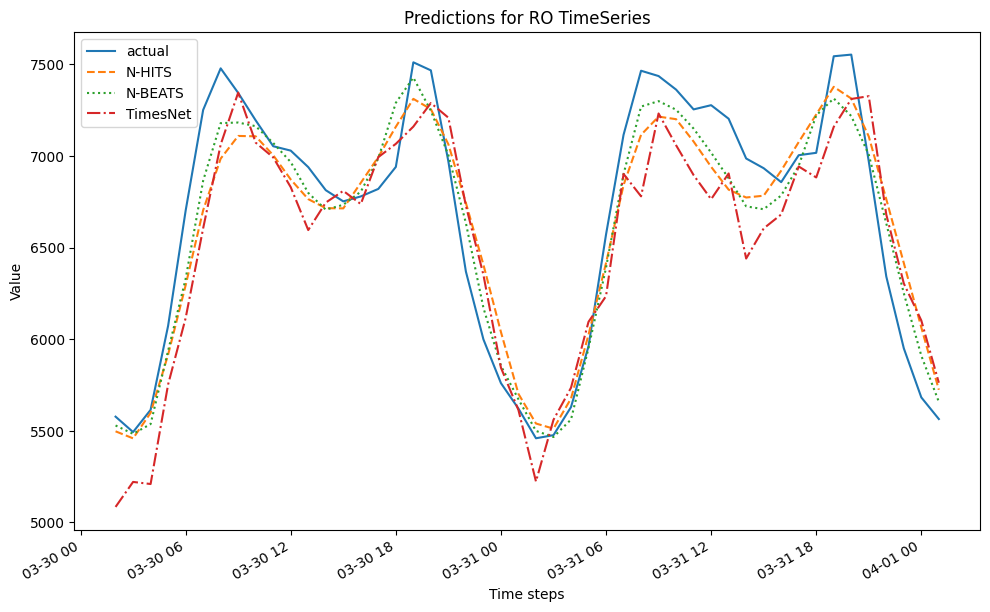

In [259]:
fig, ax = plt.subplots()

ax.plot(preds_df_pivot['y_RO'], label='actual')
ax.plot(preds_df_pivot['NHITS_RO'], label='N-HITS', ls='--')
ax.plot(preds_df_pivot['NBEATS_RO'], label='N-BEATS', ls=':')
ax.plot(preds_df_pivot['TimesNet_RO'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Predictions for RO TimeSeries')

**Plot all the TimeSeries together**

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>],
      dtype=object)

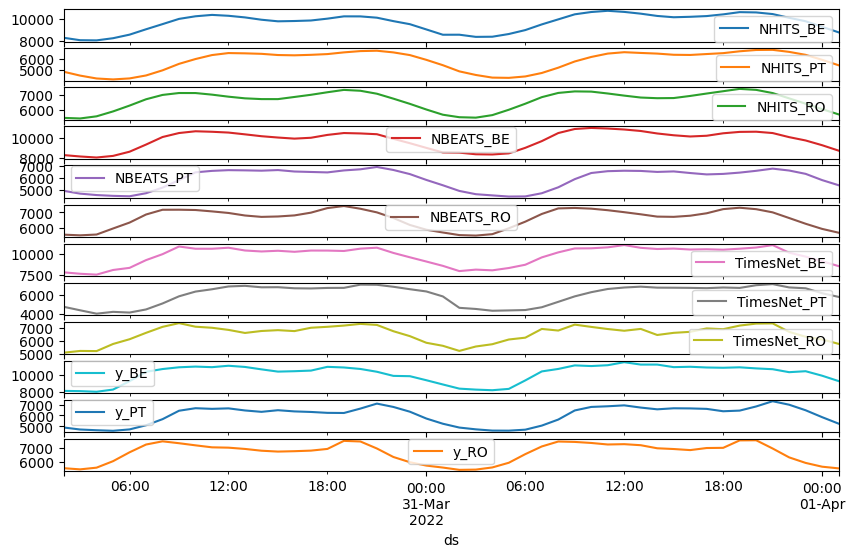

In [260]:
preds_df_pivot.plot(subplots=True, legend=True)

**Average Results for all the TimeSeries Combined**

In [266]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y']), mape(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y']), mape(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y']), mape(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse', 'mape']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,333.705214,251.999207,345.764506
mse,182866.758003,107196.571766,162818.100462
mape,0.044135,0.032923,0.048781


**Results for all the BE TimeSeries**

In [267]:
data = {'N-HiTS': [mae(preds_df_pivot['NHITS_BE'], preds_df_pivot['y_BE']), mse(preds_df_pivot['NHITS_BE'], preds_df_pivot['y_BE']), mape(preds_df_pivot['NHITS_BE'], preds_df_pivot['y_BE'])],
       'N-BEATS': [mae(preds_df_pivot['NBEATS_BE'], preds_df_pivot['y_BE']), mse(preds_df_pivot['NBEATS_BE'], preds_df_pivot['y_BE']), mape(preds_df_pivot['NBEATS_BE'], preds_df_pivot['y_BE'])],
       'TimesNet': [mae(preds_df_pivot['TimesNet_BE'], preds_df_pivot['y_BE']), mse(preds_df_pivot['TimesNet_BE'], preds_df_pivot['y_BE']), mape(preds_df_pivot['TimesNet_BE'], preds_df_pivot['y_BE'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse', 'mape']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,531.755280,395.981038,419.892222
mse,377655.683918,218394.227032,235436.025667
mape,0.054153,0.040056,0.043953


**Results for all the PT TimeSeries**

In [268]:
data = {'N-HiTS': [mae(preds_df_pivot['NHITS_PT'], preds_df_pivot['y_PT']), mse(preds_df_pivot['NHITS_PT'], preds_df_pivot['y_PT']), mape(preds_df_pivot['NHITS_PT'], preds_df_pivot['y_PT'])],
       'N-BEATS': [mae(preds_df_pivot['NBEATS_PT'], preds_df_pivot['y_PT']), mse(preds_df_pivot['NBEATS_PT'], preds_df_pivot['y_PT']), mape(preds_df_pivot['NBEATS_PT'], preds_df_pivot['y_PT'])],
       'TimesNet': [mae(preds_df_pivot['TimesNet_PT'], preds_df_pivot['y_PT']), mse(preds_df_pivot['TimesNet_PT'], preds_df_pivot['y_PT']), mape(preds_df_pivot['TimesNet_PT'], preds_df_pivot['y_PT'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse', 'mape']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,268.231069,207.522959,348.313395
mse,111875.192816,67912.215000,152916.866708
mape,0.048198,0.036032,0.060624


**Results for all the RO TimeSeries**

In [269]:
data = {'N-HiTS': [mae(preds_df_pivot['NHITS_RO'], preds_df_pivot['y_RO']), mse(preds_df_pivot['NHITS_RO'], preds_df_pivot['y_RO']), mape(preds_df_pivot['NHITS_RO'], preds_df_pivot['y_RO'])],
       'N-BEATS': [mae(preds_df_pivot['NBEATS_RO'], preds_df_pivot['y_RO']), mse(preds_df_pivot['NBEATS_RO'], preds_df_pivot['y_RO']), mape(preds_df_pivot['NBEATS_RO'], preds_df_pivot['y_RO'])],
       'TimesNet': [mae(preds_df_pivot['TimesNet_RO'], preds_df_pivot['y_RO']), mse(preds_df_pivot['TimesNet_RO'], preds_df_pivot['y_RO']), mape(preds_df_pivot['TimesNet_RO'], preds_df_pivot['y_RO'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse', 'mape']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,201.129293,152.493622,269.087901
mse,59069.397275,35283.273265,100101.409011
mape,0.030053,0.022680,0.041766
